In [4]:
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [32]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import numpy as np

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
path = datasets.download_data(MNIST_URL, ext='.gz'); path

with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [75]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [7]:
test_eq(c, 28*28)

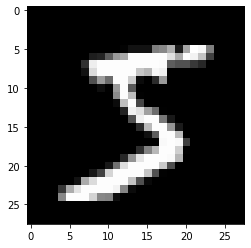

In [9]:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
img.view(28,28).type()
plt.imshow(img.view((28,28)));

In [137]:
weights = torch.randn(784,10)
bias = torch.zeros(10)
print(weights)
print(bias)

tensor([[ 0.0862, -1.8194, -2.4472,  ...,  0.6164,  0.5902,  0.0877],
        [-1.7994, -0.5065, -0.0172,  ..., -0.3708,  0.4628,  1.0759],
        [-0.2342,  0.7909, -0.2078,  ..., -0.0762, -1.5426, -0.8851],
        ...,
        [ 0.7480,  1.9494, -0.5641,  ...,  2.4249,  1.3435,  0.4336],
        [-0.1440, -1.5412,  0.6301,  ...,  0.1098, -0.3057, -2.2693],
        [ 0.0378, -0.1596,  2.4923,  ..., -0.4856, -1.4250, -0.1896]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


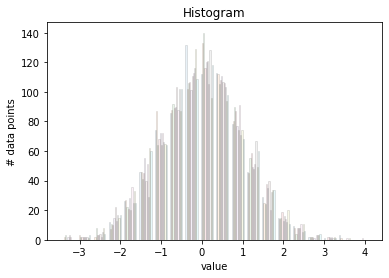

In [138]:
data = weights.numpy()
num_of_bins = 20
fig, ax = plt.subplots()
ax.hist(data, bins=num_of_bins, edgecolor='black', alpha=0.1)
ax.set_title("Histogram")
ax.set_xlabel("value")
ax.set_ylabel("# data points")
plt.show()

In [121]:
#naive way of doing matmul
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for a_rows in range(ar):
        for b_cols in range(bc):
            for k in range(ac): #k is equivalent to a_cols which is equal to b_rows
                c[a_rows,b_cols] += a[a_rows, k] * b[k,b_cols]
    return(c)

In [92]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [122]:
%timeit -n 10 _=matmul(m1, m2)

701 ms ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:
#element-wise matmul
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for a_rows in range(ar):
        for b_cols in range(bc):
            c[a_rows,b_cols] = (a[a_rows, :] * b[:,b_cols]).sum()
    return(c)

In [120]:
%timeit -n 10 _=matmul(m1, m2)

1.05 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [116]:
#broadcasting matmul
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for a_rows in range(ar):
        c[a_rows]= (a[a_rows].unsqueeze(-1) * b).sum(dim=0)
    return(c)

In [118]:
%timeit -n 10 _=matmul(m1, m2)

258 µs ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [125]:
#einstein summation matmul
#c[i,j] += a[i,k] * b[k,j]
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [126]:
%timeit -n 10 _=matmul(m1, m2)

60.8 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [129]:
#pytorch matmul
%timeit -n 10 m1.matmul(m2)
%timeit -n 10 m1@m2

The slowest run took 11.52 times longer than the fastest. This could mean that an intermediate result is being cached.
13.1 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 9.05 times longer than the fastest. This could mean that an intermediate result is being cached.
11.7 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
